# Kaggle Cassava Leaf Competition

This notebook briefly documents my final model for the [Cassava Leaf Disease Classification competition](https://www.kaggle.com/c/cassava-leaf-disease-classification) currently on Kaggle. After building half a dozen models over the last two weeks I have achieved a maximum accuracy of 89.4% on the withheld test set. Although this accuracy is very similar to the current first place score of 90.5%, it is still a world a way in Kaggle competition terms. With this final model I hope to receive a small boost in accuracy by consolidating additional data I have found from a previous competition and will include a batch of unlabelled data.

## Download and prepare the data
The competition dataset contains 21,397 images.
To expand my dataset and attempt to make the model more accurate, I also downloaded an additional 5,600 labelled images from an old competition dataset. In addition to this, I found an extra 12,596 images of cassava leaves belonging to the same five classes as the competition dataset. To expand even further, I will first train a model on the labelled data and then use it for inference on the unlabelled set. Then I will take the images where the model predicted their class value with very high confidence and add them as additional pseudo-labelled data to the overall dataset.

In [4]:
url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13836/1718836/compressed/train_images.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1607653419&Signature=qVDAZiv7WLmZsHSua7PXj57fzvLpLWcDCKAHP%2BuVWvGfKUIiFoo1JZ6XZbK3Ro%2BKeSuisVoJlt5nkQAnyMX0vglWyTRSSaC%2BKwkKvjHBPVNeGtlNXLXGdixKMWePMUEgQXC1XCw8m70T3RdTxPr5NX0vi93DrhjDcciETULct%2B84akCwV551Eowsy5%2Fy%2FLXA%2FsqrIjSHnICA5O6C8eiQSDOEVsCUpNXN262mDIZ3CM3wAcx%2Fm00hyLEaNAmAlSRyr9Im7At6ORZbH2t71aET5oYWgoHcyEL280h1mOgrSVO%2F5L6cJaS4pE9m6DixJUa1J3NUBPjsfcaWjHGbJ%2BuNkg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain_images.zip'
wget.download(url, 'comp_train.zip')

'comp_train.zip'

In [ ]:
!mkdir leaf
!unzip comp_train.zip -d leaf/train

In [ ]:
!unzip train2.zip -d leaf/train2

In [8]:
path = Path('leaf')
path.ls()

(#2) [Path('leaf/train'),Path('leaf/train2')]

In [ ]:
!unzip extraimages.zip -d leaf/extras

In [13]:
unlabelled_imgs = (path/'extras/extraimages')
unlabelled_imgs.ls()

(#12596) [Path('leaf/extras/extraimages/extra-image-13099.jpg'),Path('leaf/extras/extraimages/extra-image-3716.jpg'),Path('leaf/extras/extraimages/extra-image-14330.jpg'),Path('leaf/extras/extraimages/extra-image-15689.jpg'),Path('leaf/extras/extraimages/extra-image-14863.jpg'),Path('leaf/extras/extraimages/extra-image-6811.jpg'),Path('leaf/extras/extraimages/extra-image-11460.jpg'),Path('leaf/extras/extraimages/extra-image-7662.jpg'),Path('leaf/extras/extraimages/extra-image-14235.jpg'),Path('leaf/extras/extraimages/extra-image-2074.jpg')...]

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
with open('/content/drive/My Drive/train.csv') as f:
  df = pd.read_csv(f)

In [21]:
df['image_id'] = df['image_id'].apply(lambda x: f'train/{x}')
df.head()

,image_id,label
0,train/1000015157.jpg,0
1,train/1000201771.jpg,3
2,train/100042118.jpg,1
3,train/1000723321.jpg,1
4,train/1000812911.jpg,3


In [22]:
map_classes = {
    "0": "cbb",
    "1": "cbsd",
    "2": "cgm",
    "3": "cmd",
    "4": "healthy"
}

In [23]:
df['class'] = df['label'].astype(str).map(map_classes)
df = df.drop(columns=['label'])
df.head(), df.shape

(               image_id class
 0  train/1000015157.jpg   cbb
 1  train/1000201771.jpg   cmd
 2   train/100042118.jpg  cbsd
 3  train/1000723321.jpg  cbsd
 4  train/1000812911.jpg   cmd, (21397, 2))

In [24]:
base_train_pth = (path/'train2/train')

In [25]:
dict_lst = []

for dir in base_train_pth.ls():
  for file in dir.ls():
    dir_name = file.parent.name
    f_path = str(file)[18:]
    clean_path = f_path[len(dir_name):] 
    
    dict_lst.append({'image_id': f'train{clean_path}', 'class': f'{dir_name}'})


Merging the two sets of labelled images, I now have 27,053 images to use for training. However I will use 15% of these images as a validation set to train the model.

In [26]:
df = df.append(dict_lst, True)
df.shape

(27053, 2)

We can see from the graph below that the dataset is quite significantly imbalanced with cmd (Cassava Mosaic Disease) accounting for almost 16,000 images out of 27,053. However hopefully we have enough images of each type of disease for the CNN to learn enough features to make accurate predictions for each class.

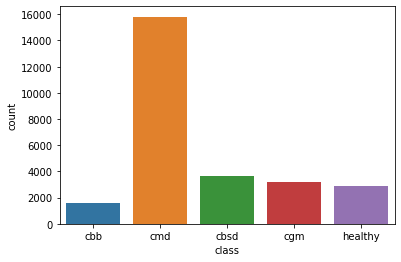

In [92]:
sns.countplot(df['class'])

I experimented a lot with different data augmentations on a subset of the data so I could quickly find which parameters were yielding better results. In the end I left most of the fastai ```aug_transforms``` function on default settings and found that blowing the image size up to 1200 and then random resize cropping down to 700 (which is around the average image size in the dataset) works well for good results. Flipping the images vertically reduced accuracy.

In [27]:
blocks = (ImageBlock, CategoryBlock)
def get_x(r): return path/r['image_id']
def get_y(r): return r['class']
item_tfms = Resize(1200)
batch_tfms = aug_transforms(size=700, max_lighting=0.2, flip_vert=False, max_rotate=15.0, min_scale=0.70)

In [28]:
main_block = DataBlock(blocks = blocks,
                  splitter = RandomSplitter(valid_pct=0.15),
                  get_x = get_x,
                  get_y = get_y,
                  item_tfms = item_tfms,
                  batch_tfms = batch_tfms)

In [29]:
main_dls = main_block.dataloaders(df, bs=28)

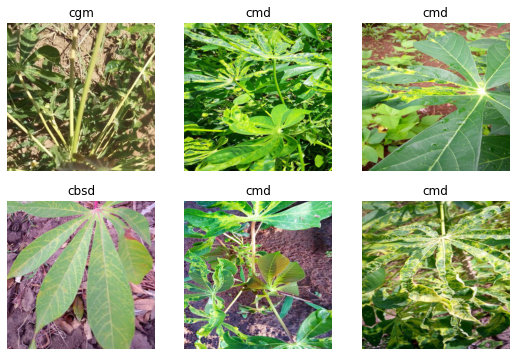

In [83]:
main_dls.show_batch(max_n=6)

## Training the first model
This model uses transfer learning with ResNet50 and uses cross entropy for the loss function. Fastai's ```fine_tune``` method trains the first epoch only on the randomly initialised layers that have been added to the pre-trained model and then 'unfreezes' the other layers and continues training all layers for the remaining epochs. Here I trained for 8 epochs in total and recieved an accuracy of 89.69% on the validation set.

In my experience from training several models for this competition, the model generalises very well to the test set and the accuracy recieved when submitting to Kaggle is almost always the same as recieved on the validation set

In [30]:
main_learner = cnn_learner(main_dls, resnet50, metrics=accuracy).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [28]:
main_learner.fine_tune(7)

epoch,train_loss,valid_loss,accuracy,time
0,0.690630,0.588408,0.802317,19:00


epoch,train_loss,valid_loss,accuracy,time
0,0.465602,0.415724,0.870348,22:28
1,0.444149,0.432029,0.859502,22:13
2,0.428360,0.421088,0.863446,22:25
3,0.356730,0.366144,0.876510,22:16
4,0.345323,0.356473,0.882672,22:39
5,0.254021,0.333151,0.893517,22:43
6,0.256352,0.331851,0.896968,22:26


## Inference on the unlabelled data

Now I use the model I just trained to do inference on the extra unlabelled data. I spent some time looking through the images from the various data sources and they all seemed to be very similar. Given this, I assume my model will correctly label around 90% of the images from this new dataset. Because I plan to add these images to my current dataset for training a model, I need to minimise the amount of incorrectly labelled images as they will have a detrimental effect on the model's accuracy.



In [39]:
test_dls = main_dls.test_dl(unlabelled_imgs.ls())

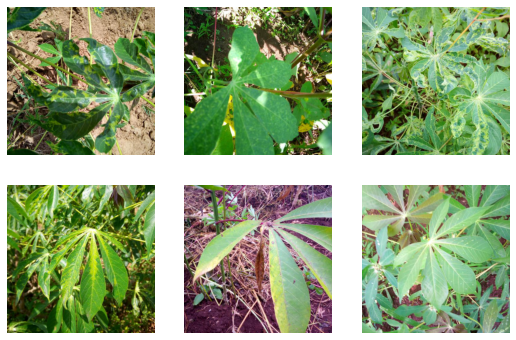

In [84]:
test_dls.show_batch(max_n=6)

In [41]:
preds, _ = main_learner.tta(dl=test_dls)

In [42]:
df2 = pd.DataFrame(columns = ['image_id', 'label', 'confidence'])

In [43]:
pred_vals = torch.max(preds, dim=-1)
df2['label'] = pred_vals.indices.numpy()
df2['confidence'] = pred_vals.values.numpy()

In [44]:
df2.head()

,image_id,label,confidence
0,NaN,3,0.999529
1,NaN,2,0.854078
2,NaN,3,0.998108
3,NaN,3,0.968962
4,NaN,0,0.515554


In [51]:
pth_lst = []
for img_pth in unlabelled_imgs.ls():
  pth_lst.append(str(img_pth)[24:])

In [52]:
df2['image_id'] = pth_lst

Now I have a new DataFrame with all the image names, labels and confidence scores for the unlabelled dataset.

In [63]:
df2.head(), df2.shape

(                image_id  label  confidence
 0  extra-image-13099.jpg      3    0.999529
 1   extra-image-3716.jpg      2    0.854078
 2  extra-image-14330.jpg      3    0.998108
 3  extra-image-15689.jpg      3    0.968962
 4  extra-image-14863.jpg      0    0.515554, (12595, 3))

In [54]:
cp -a ./leaf/extras/extraimages/. ./leaf/train/

Most images were classified with a confidence of 90% or greater. I will try to be conservative and only take images that were classified with a confidence of 95% or greater. This means I won't be gaining as much extra data, but I can be more certain the data I am getting is accurate.

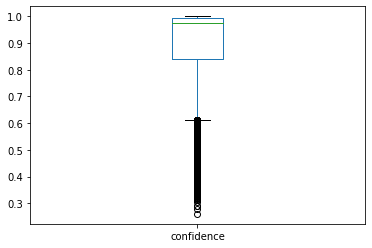

In [55]:
df2['confidence'].plot.box()

In [62]:
df3 = df2[df2['confidence']>0.95].copy()
df3.shape

(7513, 3)

In [ ]:
df3['class'] = df3['label'].astype(str).map(map_classes)
df3 = df3.drop(columns=['label', 'confidence'])
df3.head(), df3.shape

In [ ]:
df3['image_id'] = df3['image_id'].apply(lambda x: f'extras/extraimages/{x}')
df3.head()

In [69]:
final_data = df.append(df3)
final_data

,image_id,class
0,train/1000015157.jpg,cbb
1,train/1000201771.jpg,cmd
2,train/100042118.jpg,cbsd
3,train/1000723321.jpg,cbsd
4,train/1000812911.jpg,cmd
...,...,...
12584,extras/extraimages/extra-image-11410.jpg,cmd
12586,extras/extraimages/extra-image-14282.jpg,cmd
12589,extras/extraimages/extra-image-11549.jpg,cgm
12592,extras/extraimages/extra-image-10956.jpg,cmd


We can see that the new data is even more imbalanced with more than 6,000 of the 7,513 images being from the cmd (Cassava Mosaic Disease) class. This is likely due to the dataset being imbalanced to begin with like the other datasets but also from the model being the most confident in classifying the cmd class itself which leads to mostly cmd images getting through the 95% threshold test. Unfortunately this probably means that the new data will not be too much help, but we will continue anyway.

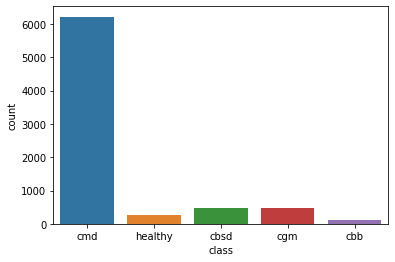

In [93]:
sns.countplot(df3['class'])

## Retraining the Model
I decided to retrain the model from scratch with the full dataset. This time I used fastai's ```lr_find``` method to find a good learning rate by plotting it against the loss function on a mini-epoch. This allows me to use a greater learning rate that will train the model faster and is supposed to have better success in generalising.

In [70]:
final_dls = main_block.dataloaders(final_data, bs=28)

In [74]:
final_learner = cnn_learner(final_dls, resnet50, metrics=accuracy).to_fp16()

In [75]:
final_learner.loss_func = LabelSmoothingCrossEntropy()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=1.5848931980144698e-06)

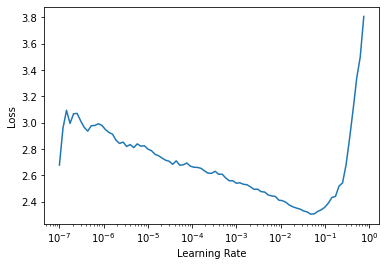

In [76]:
final_learner.lr_find()

In [77]:
final_learner.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.909822,0.777522,0.831211,28:26


epoch,train_loss,valid_loss,accuracy,time
0,0.684484,0.628349,0.896991,33:23
1,0.609434,0.581203,0.915895,33:22


The high learning rate has worked well and the accuracy is 91.58% on the validation set after just three epochs. Now I unfreeze all the layers of the model, calculate a new learning rate and train further. The learning rate function is sloping upward now as the model has already learned all the 'low hanging fruit' in its first few epochs.

In [78]:
final_learner.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

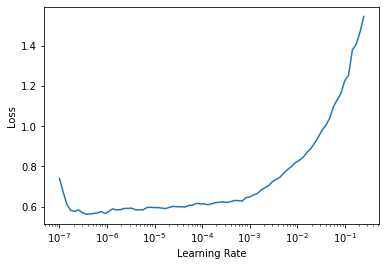

In [79]:
final_learner.lr_find()

The additional three epochs of training didn't seem to do much and the accuracy actually dropped slightly. Although the validation loss went down slightly as well so at least the model probably didn't do any overfitting on those epochs.

I saved and submitted the model to Kaggle and received a score of 88.5% for this model which marks about a 1% drop in accuracy from the models I built solely on the competition data. This might be because the additional images I found from other sources have some slight differences in them from the competition set which might lower the accuracy slightly on the competition test set. Another reason could be the addition of misclassified images from unlabelled set that I ran inference on.

In [80]:
final_learner.fit_one_cycle(3, lr_max=slice(6e-7, 1e-5), cbs=EarlyStoppingCallback())

epoch,train_loss,valid_loss,accuracy,time
0,0.598469,0.590895,0.912423,33:19
1,0.584755,0.582810,0.912230,33:31
2,0.592730,0.580823,0.914931,33:24


In [81]:
final_learner.save('final_model')

Path('models/final_model.pth')